# Data management

## Project - Financial modeling using Python - The case of Mithra

## [Paul Sibille](https://github.com/Paulsibille) & [Gurminder Singh](https://github.com/GurminSingh)

## HEC Liège | [ECON2306]()

## 0. Import procedures and important information related to your file

In [1]:
path = "/Users/paulsibille/Desktop/HECMAS1/DATAMANAGEMENT/chromedriver_mac64"
import pandas as pd
import numpy as np
import xlsxwriter
import statistics as stat
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import os
from selenium.webdriver.common.by import By
import quandl
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Cleaning and Import of the CF Statement, the Income Statement and the Balance Sheet 

This part of the code aims to clean the data. For instance, in the excel file, you may note that there are some blank lines. This part of the code has a goal to delete those empty lines. 

**Notes:** Here, we import the file 'Mithra_statement.xlsx'. When performing an analysis for another company, you need to change the excel file for the income statement, balance sheet and cash flow statement.

In [2]:
your_company='MITRA.BR'
country='Belgium'
all_statements_path = 'Mithra_statement.xlsx'
def load_and_clean_statement_df(statements_path, sheet_name):
    df = pd.read_excel(statements_path, sheet_name=sheet_name,index_col=0)
    df = df.replace('-', np.nan)
    df = df.dropna(how='all')
    df = df.fillna(0) 
    return df
inc_df = load_and_clean_statement_df(all_statements_path, 'Income Statement')
ca_df = load_and_clean_statement_df(all_statements_path, 'Cash Flow')
bs_df = load_and_clean_statement_df(all_statements_path, 'Balance Sheet')

Here is a quick overview of the three different statements we have uploaded and cleaned from the Excel file:

   - The 'inc_df' dataframe represents the income statement. This statement illustrates how the income is computed from the revenues.

   - The 'ca_df' dataframe represents the cash flow statement. This statement shows the cash flows generated by the company over the year, reflecting its true liquidity. There are three different categories of cash flow: cash flow from operations, cash flow from investing activities, and cash flow from financing activities.

   - The 'bs_df' dataframe represents the balance sheet. On one hand, the balance sheet displays the company's assets, cash flows, and accounts payable (money that customers have not yet paid). On the other hand, it shows the equity capital of the company as well as various liabilities, such as debt and leases.

In [3]:
inc_df.head()

,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
For the Fiscal Period Ending,,,,,,
Revenue,32.042,57.876,96.52,9.03,22.668,66.997
Total Revenue,32.042,57.876,96.52,9.03,22.668,66.997
Cost Of Goods Sold,2.595,1.571,2.487,3.457,15.724,19.623
Gross Profit,29.447,56.305,94.033,5.573,6.944,47.374
Selling General & Admin Exp.,10.431,10.956,16.313,17.367,14.386,16.775


In [4]:
ca_df.head()

,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
For the Fiscal Period Ending,,,,,,
Net Income,-35,-12.4,-26.6,-92.1,-116.9,-59.6
Depreciation & Amort.,1.536,3.62,5.302,5.697,7.776,11.94
Amort. of Goodwill and Intangibles,0.506,-0.9,0.131,3.546,1.574,0
"Depreciation & Amort., Total",2.042,2.707,5.433,9.243,9.35,11.94
Other Amortization,0.114,0.144,0.344,0.524,1.076,0


In [5]:
bs_df.head()

,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
For the Fiscal Period Ending,,,,,,
Cash And Equivalents,36.19,118.949,49.72,138.675,32.872,28.285
Short Term Investments,0,0,0.046,0.014,0,0
Total Cash & ST Investments,36.19,118.949,49.766,138.689,32.872,28.285
Accounts Receivable,25.429,5.194,22.433,56.758,17.163,67.265
Other Receivables,6.27,2.72,2.049,2.389,1.681,0


## 2. Visualisation of the past Free Cash flows (FCFF) : basic and vertical analysis

This part will be divided into 3 sections: 

   - Computation and visualisation of the Change in NWC. This step is important to compute the past FCFF of the firm
   
   - Basic analysis of the FCFF: this step gives us a clear visualisation of the past FCFF, computed thanks to the change in NWC among others
   
   - Vertical analysis of the FCFF: this step allow us to see clearly the importance of the different element that compose the FCFF

Free cash flow is an important financial measure that shows how much extra cash a company has after paying for its day-to-day expenses and investments in things like equipment or buildings. It's like the money left over that can be used for things like expanding the business, paying off debts, or giving out dividends to shareholders. When a company has positive free cash flow, it means they're bringing in more cash than they're spending. On the other hand, negative free cash flow means they might be struggling to cover their expenses. Understanding a company's free cash flow helps investors and businesses see how financially healthy and capable they are for future growth and opportunities. To compute the free cash flow, here is the step to follow: 
    
   - Add the Depreciation & Amortization to the net income. When calculating the net income of the company, these non-cash expenses are treated as regular expenses. However, since they don't involve actual cash outflows, we should add them to the net income to obtain a more accurate representation of the cash generated by the company during the year.
   - Include other non-cash expenses that were considered as regular expenses when computing the net income. It's important to note that these non-cash expenses can vary among companies.
   - Exclude the change in net working capital. Net working capital will be briefly explained below.
   - Exclude capital expenditures, which represent the investments in capital made by the firm throughout the year. For example, if the company decides to purchase a building, it will require cash outflows. Thus, cash will decrease as these capital investments necessitate cash flows.

### 2.1. Change in NWC: computation and visualisation


This first part of the code computes the change in net working capital of the company. The net working capital is the difference between the short-term assets and the short-term liabilities of the company. If the net working capital is large, it indicates that the short-term liabilities are low compared to the short-term assets. When calculating the change in net working capital, we examine how this difference varies compared to the previous year. Let's take an example to understand why we need to subtract this change from the net income in order to obtain the free cash flow.

Imagine the company has one customer and one producer. At the end of the first year, the accounts payable are €10, and the accounts receivable are €20. However, at the end of the second year, the accounts receivable increase to €30, while the accounts payable remain at €10. This means that there is an additional €10 compared to the first year that has not been paid by the customer yet. However, it has already been counted as revenue, even though the money has not been received. In other words, there is €10 more that is outstanding and not yet paid. To correct the net income, we need to subtract this unpaid revenue.

The first part of this code aims to compute the net working capital (NWC). 

In [6]:
Currents_Assets=""
Currents_Liabilities=""
ocl_list=bs_df.loc['Other Current Liabilities']
if 'Unearned Revenue, Current' in bs_df.index:
    ocl_list += bs_df.loc['Unearned Revenue, Current'] 
Net_current_assets=bs_df.loc['  Total Receivables']+bs_df.loc['Inventory']+bs_df.loc['Prepaid Exp.']+bs_df.loc['Other Current Assets']
Net_Current_Liabilities=bs_df.loc['Accounts Payable']+bs_df.loc['Accrued Exp.']+bs_df.loc['Curr. Income Taxes Payable']+ocl_list
NWC=Net_current_assets - Net_Current_Liabilities
Change_nwc = NWC - NWC.shift(1)
Change_nwc = Change_nwc.fillna(0)
Change_nwc

2017-12-31     0.000
2018-12-31     6.519
2019-12-31     6.086
2020-12-31    57.871
2021-12-31   -31.216
2022-12-31    15.636
dtype: float64

This second part of the code is designed to calculate ratios related to the net working capital (NWC). These ratios are essential for assessing the future NWC of the company. They provide valuable insights into the company's ability to manage its short-term assets and liabilities effectively

In [7]:
revenue_list=inc_df.loc['Revenue']
ar_list=bs_df.loc['  Total Receivables']
inv_list=bs_df.loc['Inventory']
peoca_list=bs_df.loc['Prepaid Exp.']

ap_list=bs_df.loc['Accounts Payable']
if 'Unearned Revenue, Current' in bs_df.index:
    ocl_list += bs_df.loc['Unearned Revenue, Current']
cost_list=inc_df.loc['Cost Of Goods Sold']
ae_list=bs_df.loc['Accrued Exp.']
oca_list=bs_df.loc['Other Current Assets']
taxe_list=bs_df.loc['Curr. Income Taxes Payable']
dso_list = []
for i in range(len(revenue_list)):
    if revenue_list[i] == 0:
        dso_list.append(0)
    else:
        dso_list.append(365*(ar_list[i]/revenue_list[i]))
        
dih_list = []
for i in range(len(cost_list)):
    if cost_list[i] == 0:
        dih_list.append(0)
    else:
        dih_list.append(365*(inv_list[i]/cost_list[i]))

Other_Current_Assets_list = []
for i in range(len(revenue_list)):
    if revenue_list[i] == 0:
        Other_Current_Assets_list.append(0)
    else:
        Other_Current_Assets_list.append((oca_list[i]/revenue_list[i]))

dpo_list = []
for i in range(len(cost_list)):
    if cost_list[i] == 0:
        dpo_list.append(0)
    else:
        dpo_list.append(365*(ap_list[i]/cost_list[i]))

Accrued_Liabilites_list = []
for i in range(len(revenue_list)):
    if revenue_list[i] == 0:
        Accrued_Liabilites_list.append(0)
    else:
        Accrued_Liabilites_list.append((ae_list[i]/revenue_list[i]))

Other_Current_Liabilities_list = []
for i in range(len(revenue_list)):
    if revenue_list[i] == 0:
        Other_Current_Liabilities_list.append(0)
    else:
        Other_Current_Liabilities_list.append((ocl_list[i]/revenue_list[i]))

Taxes_Payable_list = []
for i in range(len(revenue_list)):
    if revenue_list[i] == 0:
        Taxes_Payable_list.append(0)
    else:
        Taxes_Payable_list.append((taxe_list[i]/revenue_list[i]))

inv_turnover_list = []
for i in range(len(revenue_list)):
    if inv_list[i] == 0:
        inv_turnover_list.append(0)
    else:
        inv_turnover_list.append(inv_list[i]/cost_list[i])

receivable_turnover_list = []
for i in range(len(revenue_list)):
    if ar_list[i] == 0:
        receivable_turnover_list.append(0)
    else:
        receivable_turnover_list.append(ar_list[i]/revenue_list[i])

        
payable_turnover_list = []
for i in range(len(revenue_list)):
    if ap_list[i] == 0:
        payable_turnover_list.append(0)
    else:
        payable_turnover_list.append(ap_list[i]/cost_list[i])
        
prepaid_turnover_list=[]
for i in range(len(revenue_list)):
    if ap_list[i] == 0:
        prepaid_turnover_list.append(0)
    else:
        prepaid_turnover_list.append(peoca_list[i]/revenue_list[i])

This third part of the code provides a clear visualisation of the Change in NWC and of the additional ratios by putting them into a dataframe.

In [8]:


NWC_df = pd.DataFrame({'Revenue': inc_df.loc['Revenue'],
        'COGS': inc_df.loc['Cost Of Goods Sold'],
        'Currents_Assets':Currents_Assets,
        'Accounts_Receivable': bs_df.loc['  Total Receivables'],
        'Inventory': bs_df.loc['Inventory'],
        'Prepaid_Exp.': bs_df.loc['Prepaid Exp.'],
        'Other_Current_Assets': bs_df.loc['Other Current Assets'],
        'Net_current_assets':Net_current_assets,
        'Currents_Liabilities':Currents_Liabilities,
        'Accounts Payable':bs_df.loc['Accounts Payable'],
        'AccruedExp.':bs_df.loc['Accrued Exp.'],
        'Curr.IncomeTaxesPayable':bs_df.loc['Curr. Income Taxes Payable'],
        'OtherCurrentLiabilities':ocl_list,
        'Net_Current_Liabilities':Net_Current_Liabilities,
        'NWC':NWC,       
        'Change_nwc':Change_nwc,
        '':'',
    'Account receivables in % of Sales': receivable_turnover_list,
    'DSO': dso_list,
    'Inventory turnover': inv_turnover_list,
    'DIH': dih_list,
    'Prepaid Expenses in % of Sales':prepaid_turnover_list,
    'Other Current Assets': Other_Current_Assets_list,
    'Account payable in % of COGS': payable_turnover_list,              
    'DPO': dpo_list,
    'Accrued_Liabilites in % of Sales':Accrued_Liabilites_list,
    'Other Current Liabilities in % of Sales':Other_Current_Liabilities_list,
    'Taxes Payable in % of Sales':Taxes_Payable_list
       })

NWC_df = NWC_df.T.reset_index(drop=True)
NWC_df.columns = inc_df.columns
NWC_df.index=['Revenue','COGS',
                'Currents Assets','Accounts Receivable',
                'Inventory','Prepaid Exp.','Other Current Assets','Net current assets',
                'Currents Liabilities','Accounts Payable','Accrued Exp.','Curr.Income Taxes Payable','Other Current Liabilities','Net Current Liabilities',
                'NWC','Change_nwc','','Account receivables in % of Sales','DSO','Inventory turnover','DIH','Prepaid Expenses in % of Sales','Other Current Assets in % of Sales','Account payable in % of COGS','DPO','Accrued_Liabilites in % of Sales',
                'Other Current Liabilities in % of Sales','Taxes Payable in % of Sales']
NWC_df

,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
Revenue,32.042,57.876,96.52,9.03,22.668,66.997
COGS,2.595,1.571,2.487,3.457,15.724,19.623
Currents Assets,,,,,,
Accounts Receivable,31.699,7.914,24.482,59.147,18.844,67.265
Inventory,4.141,10.945,16.277,35.382,43.852,50.312
Prepaid Exp.,0.558,0.001,0,1.568,2.312,0
Other Current Assets,1.624,5.553,0.997,3.689,1.509,0.001
Net current assets,38.022,24.413,41.756,99.786,66.517,117.578
Currents Liabilities,,,,,,
Accounts Payable,16.141,13.071,19.449,23.325,16.915,58.082


### 2.2. FCFF Gross Analysis: computation and visualisation

In order to be concise and enhance clarity, we begin by recalculating the net income by rearranging the labels. Next, we calculate the free cash flows and consolidate the entire output into a single dataframe for improved data visualization

This firt part of the code aims to construct the net income and then the free cash flows. 

In [9]:
Gross_profit=(inc_df.loc['Revenue']-inc_df.loc['Cost Of Goods Sold'])
Opex = inc_df.loc['Selling General & Admin Exp.'] + inc_df.loc['R & D Exp.'] + inc_df.loc['Other Operating Expense/(Income)'] 
Ebit_= Gross_profit - Opex
NOPAT= Ebit_-(inc_df.loc['Income Tax Expense'])
CFO=NOPAT - Change_nwc + ca_df.loc['Depreciation & Amort., Total']


if 'Stock-Based Compensation' in ca_df.index:
    CFO += ca_df.loc['Stock-Based Compensation']

if '(Gain) Loss On Sale Of Invest.' in ca_df.index:
    CFO += ca_df.loc['(Gain) Loss On Sale Of Invest.']
    
if 'Asset Writedown & Restructuring Costs' in ca_df.index:
    CFO += ca_df.loc['Asset Writedown & Restructuring Costs']
    
if 'Other Operating Activities' in ca_df.index:
    CFO += ca_df.loc['Other Operating Activities']
FCFF=CFO- ca_df.loc['Capital Expenditure']

This second part of the code aims to incorporate the series into a dataframe to facilitate a clear visualization of the free cash flows computation. 

In [10]:

FCFF_bis_df = pd.DataFrame({'Revenue': inc_df.loc['Revenue'],
        'COGS': inc_df.loc['Cost Of Goods Sold'],
        'Gross_profit':Gross_profit,
        'SGA': inc_df.loc['Selling General & Admin Exp.'],
        'RD': inc_df.loc['R & D Exp.'],
        'Other_Operating_Expense': inc_df.loc['Other Operating Expense/(Income)'],
        'DA': ca_df.loc['Depreciation & Amort., Total'],
        'Opex':Opex,
        'Ebit_':Ebit_,
        'Income_Tax_Expense': inc_df.loc['Income Tax Expense'],
        'Net_income':NOPAT,
        'Depreciation_and_Amortization': ca_df.loc['Depreciation & Amort., Total'],
        'Stock-BasedCompensation': ca_df.loc['Stock-Based Compensation'],
        'OtherOperatingActivities': ca_df.loc['Other Operating Activities'],
        '(Gain)LossOnSaleOfInvest.': ca_df.get('(Gain) Loss On Sale Of Invest.', 0),
        'Asset_Writedown_Restructuring_Costs': ca_df.get('Asset Writedown & Restructuring Costs', 0),
        'Change_nwc':Change_nwc,
        'CFO': CFO,
        'Capital_Expenditure':ca_df.loc['Capital Expenditure'],
        'FCFF':FCFF
       })
FCFF_bis_df=FCFF_bis_df.T
FCFF_df = FCFF_bis_df.reset_index(drop=True)
FCFF_df.columns = inc_df.columns
FCFF_df.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A','Opex',
                'EBIT','Income tax expenses','Net Income','D&A',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']

FCFF_df

,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
Revenue,32.042,57.876,96.52,9.03,22.668,66.997
COGS,2.595,1.571,2.487,3.457,15.724,19.623
Gross_profit,29.447,56.305,94.033,5.573,6.944,47.374
SG&A,10.431,10.956,16.313,17.367,14.386,16.775
R&D,48.185,35.713,57.073,78.458,85.243,64.041
Other Operating Expense,-3,-4.6,-6.3,-6.6,-4.8,-7.2
D&A,2.042,2.707,5.433,9.243,9.35,11.94
Opex,55.616,42.069,67.086,89.225,94.829,73.616
EBIT,-26.169,14.236,26.947,-83.652,-87.885,-26.242
Income tax expenses,-13.1,-9.9,-4.9,-18.8,-6.9,48.139


### 2.3. FCFF Vertical Analysis: Computation and Visualisation

In finance, vertical analysis is a method of expressing numbers in relative terms. Typically, we express each item on a financial statement relative to the revenues. In other words, we will divide each label in the previous dataframe by the corresponding revenue. Later, we will discover that the statistics related to this vertical analysis are crucial for making assumptions and drawing conclusions

This first part aims to compute the vertical analysis. Here, we divide each label of each year by the revenue. 

In [11]:
list_variables = ['Revenue', 'COGS', 'Gross_profit', 'SGA', 'RD',
       'Other_Operating_Expense', 'DA', 'Opex', 'Ebit_', 'Income_Tax_Expense',
       'Net_income', 'Depreciation_and_Amortization',
       'Stock-BasedCompensation', 'OtherOperatingActivities',
       '(Gain)LossOnSaleOfInvest.', 'Asset_Writedown_Restructuring_Costs',
       'Change_nwc', 'CFO', 'Capital_Expenditure', 'FCFF']
variables = []

for variable in list_variables:
    x = FCFF_bis_df.loc[variable]/FCFF_bis_df.loc['Revenue']
    variables.append(x)

The second part of the code organizes the computed series into a dataframe, enabling a clear visualization of the data.

In [12]:
FCFF_bis_vertical=pd.DataFrame(variables)
FCFF_bis_vertical.index=['Revenue', 'COGS', 'Gross_profit', 'SGA', 'RD',
       'Other_Operating_Expense', 'DA', 'Opex', 'Ebit_', 'Income_Tax_Expense',
       'Net_income', 'Depreciation_and_Amortization',
       'Stock-BasedCompensation', 'OtherOperatingActivities',
       '(Gain)LossOnSaleOfInvest.', 'Asset_Writedown_Restructuring_Costs',
       'Change_nwc', 'CFO', 'Capital_Expenditure', 'FCFF']
FCFF_vertical=FCFF_bis_vertical.reset_index(drop=True)
FCFF_vertical.columns = inc_df.columns
FCFF_vertical.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A','Opex',
                'EBIT','Income tax expenses','Net Income','D&A',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']

FCFF_vertical

,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
Revenue,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
COGS,0.080987,0.027144,0.025767,0.382835,0.693665,0.292894
Gross_profit,0.919013,0.972856,0.974233,0.617165,0.306335,0.707106
SG&A,0.325541,0.189301,0.169012,1.923256,0.634639,0.250384
R&D,1.503808,0.617061,0.591308,8.688594,3.760499,0.955879
Other Operating Expense,-0.093627,-0.079480,-0.065271,-0.730897,-0.211752,-0.107467
D&A,0.063729,0.046772,0.056289,1.023588,0.412476,0.178217
Opex,1.735722,0.726882,0.695048,9.880952,4.183386,1.098795
EBIT,-0.816709,0.245974,0.279186,-9.263787,-3.877051,-0.391689
Income tax expenses,-0.408838,-0.171055,-0.050767,-2.081949,-0.304394,0.718525


## 3. Statistics on past FCFF

This section will calculate two essential statistics, the median and the average, for each label in the three dataframes computed earlier. For instance, if we are refering to the vertical analysis, we will compute the median and the average of the "Other Opertaing Activities" over the 6 past years. Note that, for each dataframe, we will also use the "last value" which is the value of the label for the last year (in our case, 2022).

These statistics play a crucial role in informing our assumptions and analysis. 

### 3.1. NWC ratios statistics

This code calculates the mean, median, and latest value of ratios associated with the net working capital. Here, we only compute the statistics for the ratios and not for the labels since only the statistics for those ratios will be used to make assumptions. 

In [13]:
avg_acr = stat.mean(receivable_turnover_list)
avg_dso = stat.mean(dso_list)
avg_inv = stat.mean(inv_turnover_list)
avg_dih = stat.mean(dih_list)
avg_pre = stat.mean(prepaid_turnover_list)
avg_oca = stat.mean(Other_Current_Assets_list)
avg_acp = stat.mean(payable_turnover_list)
avg_dpo = stat.mean(dpo_list)
avg_acl = stat.mean(Accrued_Liabilites_list)
avg_ocl = stat.mean(Other_Current_Liabilities_list)
avg_taxe = stat.mean(Taxes_Payable_list)

median_acr = stat.mean(receivable_turnover_list)
median_dso = stat.median(dso_list)
median_inv = stat.median(inv_turnover_list)
median_dih = stat.median(dih_list)
median_pre = stat.median(prepaid_turnover_list)
median_oca = stat.median(Other_Current_Assets_list)
median_acp = stat.mean(payable_turnover_list)
median_dpo = stat.median(dpo_list)
median_acl = stat.median(Accrued_Liabilites_list)
median_ocl = stat.median(Other_Current_Liabilities_list)
median_taxe = stat.median(Taxes_Payable_list)

last_acr = receivable_turnover_list[-1]
last_dso = dso_list[-1]
last_inv = inv_turnover_list[-1]
last_dih = dih_list[-1]
last_pre = prepaid_turnover_list[-1]
last_oca = Other_Current_Assets_list[-1]
last_acp = payable_turnover_list[-1]
last_dpo = dpo_list[-1]
last_acl = Accrued_Liabilites_list[-1]
last_ocl = Other_Current_Liabilities_list[-1]
last_taxe = Taxes_Payable_list[-1]
stat_NWC_df = pd.DataFrame({
    'Average': [avg_acr,avg_dso, avg_inv, avg_dih,avg_pre, avg_oca, avg_acp, avg_dpo, avg_acl, avg_ocl, avg_taxe],
    'Median': [median_acr, median_dso, median_inv, median_dih, median_pre, median_oca, median_acp, median_dpo, median_acl, median_ocl, median_taxe],
    'Last Value': [last_acr, last_dso, last_inv, last_dih, last_pre, last_oca, last_acr, last_dpo, last_acl, last_ocl, last_taxe]
})
stat_NWC_df.index=['Account receivables in % of Sales','DSO','Inventory Turnover','DIH', 'Prepaid Expenses in % of Sales', 'Other Current Assets in % of Sales','Account payable in % of COGS','DPO','Accrued_Liabilites in % of Sales',
                'Other Current Liabilities in % of Sales','Taxes Payable in % of Sales']
stat_NWC_df

,Average,Median,Last Value
Account receivables in % of Sales,1.627507,1.627507,1.004000
DSO,594.040081,332.259380,366.460065
Inventory Turnover,5.115861,4.666845,2.563930
DIH,1867.289380,1703.398595,935.834480
Prepaid Expenses in % of Sales,0.048845,0.008716,0.000000
Other Current Assets in % of Sales,0.105345,0.058627,0.000015
Account payable in % of COGS,5.523883,5.523883,1.004000
DPO,2016.217409,2366.517316,1080.361311
Accrued_Liabilites in % of Sales,0.061203,0.024090,0.000000
Other Current Liabilities in % of Sales,0.264016,0.139538,0.038241


### 3.2. Gross Analysis statistics

This code computes the mean, median, and latest value for each label that compose the gross analysis.

In [14]:
list_variables = ['Revenue', 'COGS', 'Gross_profit', 'SGA', 'RD',
       'Other_Operating_Expense', 'DA', 'Opex', 'Ebit_', 'Income_Tax_Expense',
       'Net_income', 'Depreciation_and_Amortization',
       'Stock-BasedCompensation', 'OtherOperatingActivities',
       '(Gain)LossOnSaleOfInvest.', 'Asset_Writedown_Restructuring_Costs',
       'Change_nwc', 'CFO', 'Capital_Expenditure', 'FCFF']
avg_variable=[]
median_variable=[]
last_variable=[]
for variables in list_variables: 
    variables_list=FCFF_bis_df.loc[variables]
    avg_variable.append(stat.mean(variables_list))
    median_variable.append(stat.median(variables_list))
    last_variable.append(variables_list[-1])
stat_FCFF_df = pd.DataFrame({
    'Average': avg_variable,
    'Median': median_variable,
    'Last Value': last_variable
}) 
stat_FCFF_df.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A','Opex',
                'EBIT','Income tax expenses','Net Income','D&A',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']
stat_FCFF_df

,Average,Median,Last Value
Revenue,47.522167,44.9590,66.997
COGS,7.576167,3.0260,19.623
Gross_profit,39.946000,38.4105,47.374
SG&A,14.371333,15.3495,16.775
R&D,61.452167,60.5570,64.041
Other Operating Expense,-5.416667,-5.5500,-7.200
D&A,6.785833,7.3380,11.940
Opex,70.406833,70.3510,73.616
EBIT,-30.460833,-26.2055,-26.242
Income tax expenses,-0.910167,-8.4000,48.139


### 3.3. Vertical analysis statistics

This code aims to compute the mean, the median, and the last value for each label of the vertical analysis. 

In [15]:
list_variables = ['Revenue', 'COGS', 'Gross_profit', 'SGA', 'RD',
       'Other_Operating_Expense', 'DA', 'Opex', 'Ebit_', 'Income_Tax_Expense',
       'Net_income', 'Depreciation_and_Amortization',
       'Stock-BasedCompensation', 'OtherOperatingActivities',
       '(Gain)LossOnSaleOfInvest.', 'Asset_Writedown_Restructuring_Costs',
       'Change_nwc', 'CFO', 'Capital_Expenditure', 'FCFF']
avg_pct_variable=[]
median_pct_variable=[]
last_pct_variable=[]
for variables in list_variables: 
    variables_list=FCFF_bis_vertical.loc[variables]
    avg_pct_variable.append(stat.mean(variables_list))
    median_pct_variable.append(stat.median(variables_list))
    last_pct_variable.append(variables_list[-1])
stat_FCFF_vertical_df = pd.DataFrame({
    'Average': avg_pct_variable,
    'Median': median_pct_variable,
    'Last Value': last_pct_variable
}) 
stat_FCFF_vertical_df.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A','Opex',
                'EBIT','Income tax expenses','Net Income','D&A',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']
stat_FCFF_vertical_df

,Average,Median,Last Value
Revenue,1.000000,1.000000,1.000000
COGS,0.250549,0.186941,0.292894
Gross_profit,0.749451,0.813059,0.707106
SG&A,0.582022,0.287963,0.250384
R&D,2.686191,1.229843,0.955879
Other Operating Expense,-0.214749,-0.100547,-0.107467
D&A,0.296845,0.120973,0.178217
Opex,3.053464,1.417259,1.098795
EBIT,-2.304013,-0.604199,-0.391689
Income tax expenses,-0.383080,-0.237725,0.718525


## 4. Assumptions

This part creates the assumptions that will support the future forecast we make. Usually, many labels are forecasted by taking the mean or the median of the past labels' values per revenue (average of the past values of the vertical analysis for each label). For instance, we will make the forecast for the "other operating activities" by assuming that the mean of the past values is a good prediction for the future. However, for some other labels, such as the revenues, the COGS (cost of goods sold), and the operating expenses, more realistic and complex assumptions must be made.

In other words, this part is much more considered as a draft and is really **specific to the company**. You may want to keep the average of the past years to determine the future values for your company. This is up to you and the qualitative analysis you have made.

For Mithra, we will take the mean as a clever assumption for the future of the company. But some other assumptions, such as the ones on revenues and COGS, are linked to the qualitative analysis that has been performed. Moreover, for some other labels such as D&A (depreciation and amortization), operating expenses, and Capex (capital expenditures), the mean or median has been calculated for specific past years rather than the whole past years.

### 4.1. Assumptions on revenues

In this part, we have decomposed the revenues of Mithra into the four "segments" of their business. Accurate assumptions have been made based on a qualitative analysis and estimations given in some reports, etc.

In [16]:
Assumption_revenues_list=[]
Assumption_revenues_df=pd.DataFrame(Assumption_revenues_list)
Assumption_revenues_df.index=['2023','2024','2025','2026','2027','2028']
labels_revenues=['Sales Estelle','License Estelle','Sales Donesta','License Donesta','Sales Myring','License Myring','Others']
Assumption_revenues_df['Sales Estelle']=[47.93,64.14,113.51,92.43,132.64,192.96]
Assumption_revenues_df['Sales Donesta']=[15,12.8,34.9,14.2,31.1,33.3]
Assumption_revenues_df['Sales Myring']=[7.14,8.94,14.92,10.64,11.79,12.74]
Assumption_revenues_df['Sales Other']=[0.92,1.41,2.15,3.29,5.04,7.72]
total_sales_list=[]
for year in Assumption_revenues_df.index:
    total_sales_list.append(sum(Assumption_revenues_df.T[year]))
    
Assumption_revenues_df['Total']=total_sales_list
Assumption_revenues_df=Assumption_revenues_df.T
Assumption_revenues_df

,2023,2024,2025,2026,2027,2028
Sales Estelle,47.93,64.14,113.51,92.43,132.64,192.96
Sales Donesta,15.00,12.80,34.90,14.20,31.10,33.30
Sales Myring,7.14,8.94,14.92,10.64,11.79,12.74
Sales Other,0.92,1.41,2.15,3.29,5.04,7.72
Total,70.99,87.29,165.48,120.56,180.57,246.72


### 4.2. Specific assumptions on other labels

Here, we are forecasting the other labels that require a better approximation than only the mean (or median) of all past years. For instance, the COGS (Cost of Goods Sold) is specified as specific numbers since they are the result of a qualitative analysis and several estimations read in several reports. For SG&A (Selling, General, and Administrative expenses), R&D (Research and Development) expenses, other operating expenses, capital expenditures, and D&A (Depreciation and Amortization), we have chosen to only take into account some of the past years in the computation of the mean rather than all years. This is due to the fact that Mithra is a small company and therefore more sensitive to extreme values. Note that for those extreme values, taking the mean for only the significant numbers was better than the median for all numbers since the sample size for each label is small (6 observations per label), leading to a less efficient "central tendency."

Moreover, for SG&A (Selling, General, and Administrative expenses) and R&D (Research and Development) expenses, which are operating expenses (OpEx), we have decided to reduce the ratio by 2% per year. This reduction reflects the anticipated efficiency improvement of the company over the coming years.

Finally, a last modification occurs for the Income tax expenses. Indeed, it is much better to forecast the effective tax rate (Income Tax Expenses/EBIT) rather than forecast the ratio "Income Tax Expenses/Revenues" since it is more realistic and provides a better estimation of the tax expenses relative to the company's profitability.

In [17]:
choice_list=[]
draft_futurV_FCFF_df=pd.DataFrame(choice_list)

draft_futurV_FCFF_df.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A1','Opex',
                'EBIT','Income tax expenses','Net Income','D&A2',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']
year_to_forecast=['2023','2024','2025','2026','2027','2028']
reduction_RD=0.02
reduction_SGA=0.02
for year in year_to_forecast:
    draft_futurV_FCFF_df[year]=avg_pct_variable
    draft_futurV_FCFF_df[year]['SG&A']=stat.mean(FCFF_vertical.loc['SG&A',['2017-12-31','2018-12-31','2019-12-31','2021-12-31','2022-12-31']])-reduction_SGA
    draft_futurV_FCFF_df[year]['R&D']=stat.mean(FCFF_vertical.loc['R&D',['2018-12-31','2019-12-31']])-reduction_RD
    draft_futurV_FCFF_df[year]['Other Operating Expense']=stat.mean(FCFF_vertical.loc['Other Operating Expense',['2017-12-31','2018-12-31','2019-12-31','2021-12-31','2022-12-31']])
    draft_futurV_FCFF_df[year]['Opex']=sum([draft_futurV_FCFF_df[year]['SG&A'],draft_futurV_FCFF_df[year]['R&D'],draft_futurV_FCFF_df[year]['Other Operating Expense']])
    draft_futurV_FCFF_df[year]['Capital Expenditure']=stat.mean(FCFF_vertical.loc['Capital Expenditure',['2017-12-31','2018-12-31','2019-12-31','2021-12-31','2022-12-31']])
    draft_futurV_FCFF_df[year]['D&A1']=stat.mean(FCFF_bis_vertical.loc['DA',['2019-12-31','2020-12-31','2021-12-31',]]/-FCFF_vertical.loc['Capital Expenditure',['2019-12-31','2020-12-31','2021-12-31']])
    draft_futurV_FCFF_df[year]['D&A2']=stat.mean(FCFF_bis_vertical.loc['DA',['2019-12-31','2020-12-31','2021-12-31',]]/-FCFF_vertical.loc['Capital Expenditure',['2019-12-31','2020-12-31','2021-12-31']])
    reduction_RD+=0.01
    reduction_SGA+=0.02
draft_futurV_FCFF_df.loc['COGS']=[0.2874, 0.2662, 0.1834, 0.2083, 0.1627, 0.1289]
draft_futurV_FCFF_df.loc['Income tax expenses']=stat.median(np.absolute(FCFF_df.loc['Income tax expenses',['2017-12-31','2018-12-31','2019-12-31','2020-12-31','2021-12-31']]/FCFF_df.loc['EBIT',['2017-12-31','2018-12-31','2019-12-31','2020-12-31','2021-12-31']]))

draft_futurV_FCFF_df

,2023,2024,2025,2026,2027,2028
Revenue,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
COGS,0.287400,0.266200,0.183400,0.208300,0.162700,0.128900
Gross_profit,0.749451,0.749451,0.749451,0.749451,0.749451,0.749451
SG&A,0.293776,0.273776,0.253776,0.233776,0.213776,0.193776
R&D,0.584184,0.574184,0.564184,0.554184,0.544184,0.534184
Other Operating Expense,-0.111520,-0.111520,-0.111520,-0.111520,-0.111520,-0.111520
D&A1,0.724828,0.724828,0.724828,0.724828,0.724828,0.724828
Opex,0.766440,0.736440,0.706440,0.676440,0.646440,0.616440
EBIT,-2.304013,-2.304013,-2.304013,-2.304013,-2.304013,-2.304013
Income tax expenses,0.224741,0.224741,0.224741,0.224741,0.224741,0.224741


### 4.3. Forecasted gross analysis and net working capital

Now that we have made our assumptions about future revenues, COGS, etc., we can multiply the estimated ratios by the corresponding denominators.

First, we forecast the future components of the net working capital in order to finally forecast the change in net working capital. For instance, we will multiply the "accounts receivables as a percentage of Sales" by the revenue for each year. This calculation will give us the estimated value of accounts receivables based on the projected revenue for each year. Similarly, we will apply the corresponding percentages for other components of net working capital, such as inventory, accounts payable, etc., to estimate their values.

In [18]:
forecasted_revenue_list=Assumption_revenues_df.loc['Total']
forecasted_cost_list=draft_futurV_FCFF_df.loc['COGS']*Assumption_revenues_df.loc['Total']
forecasted_ar_list=stat_NWC_df.loc['Account receivables in % of Sales','Average']*forecasted_revenue_list
forecasted_inv_list=stat_NWC_df.loc['Inventory Turnover','Average']*forecasted_cost_list
forecasted_peoca_list=stat_NWC_df.loc['Prepaid Expenses in % of Sales','Average']*forecasted_revenue_list
forecasted_ap_list=stat_NWC_df.loc['Account payable in % of COGS','Average']*forecasted_cost_list
forecasted_ae_list=stat_NWC_df.loc['Accrued_Liabilites in % of Sales','Average']*forecasted_revenue_list
forecasted_oca_list=stat_NWC_df.loc['Other Current Assets in % of Sales','Average']*forecasted_revenue_list
forecasted_taxe_list=stat_NWC_df.loc['Taxes Payable in % of Sales','Average']*forecasted_revenue_list
forecasted_ocl_list=stat_NWC_df.loc['Other Current Liabilities in % of Sales','Average']*forecasted_revenue_list
forecasted_net_current_assets=forecasted_ar_list+forecasted_inv_list+forecasted_peoca_list+forecasted_oca_list
forecasted_net_current_liabilities=forecasted_ap_list+forecasted_ae_list+forecasted_taxe_list+forecasted_ocl_list
forecasted_NWC=forecasted_net_current_assets-forecasted_net_current_liabilities
forecasted_change_NWC= forecasted_NWC - forecasted_NWC.shift(1)
forecasted_change_NWC_2023=forecasted_NWC['2023']-NWC['2022-12-31']
forecasted_change_NWC=forecasted_change_NWC.fillna(forecasted_change_NWC_2023)
forecasted_NWC_df = pd.DataFrame({'Revenue': forecasted_revenue_list,
        'COGS': forecasted_cost_list,
        'Currents_Assets':Currents_Assets,
        'Accounts_Receivable': forecasted_ar_list,
        'Inventory': forecasted_inv_list,
        'Prepaid_Exp.': forecasted_peoca_list,
        'Other_Current_Assets': forecasted_oca_list,
        'Net_current_assets':forecasted_net_current_assets,
        'Currents_Liabilities':Currents_Liabilities,
        'Accounts Payable':forecasted_ap_list,
        'AccruedExp.':forecasted_ae_list,
        'Curr.IncomeTaxesPayable':forecasted_taxe_list,
        'OtherCurrentLiabilities':forecasted_ocl_list,
        'Net_Current_Liabilities':forecasted_net_current_liabilities,
        'NWC':forecasted_NWC,       
        'Change_nwc':forecasted_change_NWC})
forecasted_NWC_df=forecasted_NWC_df.T
forecasted_NWC_df

,2023,2024,2025,2026,2027,2028
Revenue,70.99,87.29,165.48,120.56,180.57,246.72
COGS,20.402526,23.236598,30.349032,25.112648,29.378739,31.802208
Currents_Assets,,,,,,
Accounts_Receivable,115.536727,142.065092,269.31987,196.212252,293.878952,401.538544
Inventory,104.376494,118.875213,155.261439,128.472824,150.297554,162.695686
Prepaid_Exp.,3.467499,4.26367,8.082852,5.88874,8.819922,12.051011
Other_Current_Assets,7.478455,9.195581,17.432522,12.700416,19.02218,25.990764
Net_current_assets,230.859174,274.399557,450.096682,343.274232,472.018608,602.276005
Currents_Liabilities,,,,,,
Accounts Payable,112.701173,128.356256,167.644511,138.719337,162.284726,175.671686


Second, we can now compute the forecasted gross values for each category and, ultimately, calculate the forecasted values of the free cash flows. For instance, we have forecasted R&D as a percentage of revenues, so we will multiply the forecasted ratio by the revenues that we have forecasted. This multiplication will give us the estimated values for each category based on the forecasted ratios and corresponding metrics.

In [19]:
list_variables = ['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A1','Opex',
                'EBIT','Income tax expenses','Net Income','D&A2',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']
variables = []

for variable in list_variables:
    x = draft_futurV_FCFF_df.loc[variable]*Assumption_revenues_df.loc['Total']
    variables.append(x)
Futur_FCFF_df=pd.DataFrame(variables)
Futur_FCFF_df.columns = draft_futurV_FCFF_df.columns

Futur_FCFF_df.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A1','Opex',
                'EBIT','Income tax expenses','NOPAT','D&A2',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']
Futur_FCFF_df.loc['D&A1']=draft_futurV_FCFF_df.loc['D&A1']*Futur_FCFF_df.loc['Capital Expenditure']*-1
Futur_FCFF_df.loc['D&A2']=draft_futurV_FCFF_df.loc['D&A2']*Futur_FCFF_df.loc['Capital Expenditure']*-1
Futur_FCFF_df.loc['Change nwc']=forecasted_NWC_df.loc['Change_nwc']
Futur_FCFF_df.loc['Gross_profit']=Futur_FCFF_df.loc['Revenue']-Futur_FCFF_df.loc['COGS']
Futur_FCFF_df.loc['EBIT']=Futur_FCFF_df.loc['Gross_profit']-Futur_FCFF_df.loc['Opex']
Futur_FCFF_df.loc['NOPAT']=Futur_FCFF_df.loc['EBIT']-Futur_FCFF_df.loc['Income tax expenses']
Futur_FCFF_df.loc['CFO']=Futur_FCFF_df.loc['NOPAT']+Futur_FCFF_df.loc['D&A2']+Futur_FCFF_df.loc['Stock Based Compensation']+Futur_FCFF_df.loc['Other Operating Activities']+Futur_FCFF_df.loc['(Gain) Loss On Sale Of Invest']+Futur_FCFF_df.loc['Asset Writedown Restructuring Costs']-Futur_FCFF_df.loc['Change nwc']
Futur_FCFF_df.loc['FCFF']=Futur_FCFF_df.loc['CFO']+Futur_FCFF_df.loc['Capital Expenditure']
Futur_FCFF_df.loc['Income tax expenses']=draft_futurV_FCFF_df.loc['Income tax expenses']*Futur_FCFF_df.loc['EBIT']

Futur_FCFF_df.index=['Revenue','COGS','Gross_profit','SG&A','R&D','Other Operating Expense','D&A','Opex',
                'EBIT','Income tax expenses','NOPAT','D&A',
                'Stock Based Compensation','Other Operating Activities',
                '(Gain) Loss On Sale Of Invest',
                'Asset Writedown Restructuring Costs',
                'Change nwc','CFO','Capital Expenditure','FCFF']

Futur_FCFF_df

,2023,2024,2025,2026,2027,2028
Revenue,70.990000,87.290000,165.480000,120.560000,180.570000,246.720000
COGS,20.402526,23.236598,30.349032,25.112648,29.378739,31.802208
Gross_profit,50.587474,64.053402,135.130968,95.447352,151.191261,214.917792
SG&A,20.855127,23.897869,41.994781,28.183982,38.601454,47.808308
R&D,41.471226,50.120526,93.361178,66.812430,98.263315,131.793890
Other Operating Expense,-7.916785,-9.734556,-18.454283,-13.444817,-20.137115,-27.514144
D&A,12.935945,15.906165,30.154109,21.968693,32.903840,44.957830
Opex,54.409569,64.283839,116.901676,81.551595,116.727654,152.088054
EBIT,-3.822095,-0.230437,18.229292,13.895757,34.463607,62.829738
Income tax expenses,-0.858980,-0.051789,4.096862,3.122941,7.745371,14.120393


The future free cash flows are a crucial component of this framework. In finance, the enterprise value is determined by summing up all the discounted free cash flows. The enterprise value represents the total value of the company, indicating how much the company is worth if one were to acquire all of its equity, repay existing debt, and use the existing cash. It is a comprehensive measure that provides an assessment of the overall value of the business.

As mentioned, we are interested in the discounted free cash flows. As a result, we need to compute an efficient discount rate, which is called the WACC.

## 5.  WACC Computation

The WACC, for Weighted Average Cost of Capital, is important in financial modeling, specifically in DCF computation. Indeed, it can be seen as the cost the company faces for holding its capital.

There are two main kinds of stakeholders that hold capital in a company: the debtholders and the shareholders, who both "own" the company by a percentage corresponding to the amount of capital they have in the company.

The WACC can be separated into two different rates: the cost of debt and the cost of equity. To refer to what has been said above, the cost of equity determines the cost the company faces for using the capital provided by the shareholders. On the other hand, the cost of debt corresponds to the cost the company faces for using the capital offered by the debtholders.

Logically, both costs are weighted by the corresponding amount of debt and equity to compute the Weighted Average Cost of Capital.


### 5.1. The cost of Debt 

#### 5.1.1. The risk free rate 
The first important variable that composes the cost of debt is the risk-free rate. This risk-free rate can be seen as the yield you get on a treasury bond. Indeed, treasury bonds are, by definition, risk-free since a state cannot go bankrupt. Consequently, debtholders could invest their money in a treasury bond rather than in the company and get a sure annual return equal to the annual yield you get on this treasury bond.

In [20]:
url = "http://www.worldgovernmentbonds.com/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table", {"class": "homeBondTable"})
for row in table.find_all("tr"):
    if country in row.text:
        rf = row.find("td", {"class": "w3-right-align w3-bold"}).text.strip()
        rf = (float(rf.strip("%")))/100
        break 
print ("The risk free rate for",country, "is",rf)

The risk free rate for Belgium is 0.02989


#### 5.1.2. The Default Spread
The default rate can be seen as a premium. Indeed, debtholders are risk-averse, and they need to be compensated for the investment they make in the company. As a result, they will require a premium in addition to the risk-free rate, according to the rating of the company and its solvency, liquidity, and profitability. Note that this can be measured by the Interest Coverage ratio of the company, which measures how many times the current interest can be paid with Earnings Before Interest and Taxes (EBIT).

In [21]:
url = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ratings.html"
response = requests.get(url,verify=False)

soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table')

rows = table.find_all('tr')

data = []
for row in rows:
    cols = row.find_all('td')
    cols = [col.text.strip() for col in cols]
    data.append(cols)
df = pd.DataFrame(data)
df.columns=(df.iloc[0])
df=df.drop(index=[0,16])
df.iloc[:, 0:1] = df.iloc[:, 0:1].astype(float)
df.iloc[:, 3] = (df.iloc[:, 3].astype(str).str.replace('%', '').astype(float))/100
df

/Users/paulsibille/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pages.stern.nyu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


,>,≤ to,Rating is,Spread is
1,-100000.0,0.199999,D2/D,0.2000
2,0.2,0.649999,C2/C,0.1750
3,0.65,0.799999,Ca2/CC,0.1578
4,0.8,1.249999,Caa/CCC,0.1157
5,1.25,1.499999,B3/B-,0.0737
6,1.5,1.749999,B2/B,0.0526
7,1.75,1.999999,B1/B+,0.0455
8,2.0,2.2499999,Ba2/BB,0.0313
9,2.25,2.49999,Ba1/BB+,0.0242
10,2.5,2.999999,Baa2/BBB,0.0200


In [22]:
interest=inc_df.loc['  Net Interest Exp.']
ratio=Ebit_[-1]/interest[-1]
print ("The interest Coverage Ratio of the company is ",ratio)

The interest Coverage Ratio of the company is  1.929558823529412


In [23]:
i=0
while i < len(df.index):
    if float(df.iloc[i, 0]) < ratio < float(df.iloc[i, 1]):
        spread = df.iloc[i, 3]
    i+=1
print("For this Interest Coverage Ratio, debtholders are requiring a default spread of", spread)

For this Interest Coverage Ratio, debtholders are requiring a default spread of 0.0455


The table provides the relationship between the spread and the interest coverage ratio. For instance, in this case, where the interest coverage ratio of the company falls between 1.75 and 1.99, it corresponds to a default spread of 0.0455.

#### 5.1.3. The Market value of debt
This part aims to determine the market value of debt. Briefly, the market value of debt is the factor that will weigh the cost of debt to compute the WACC. Analysts use the market value of debt instead of the book value of debt because it takes into account the discounted value of the debt (market value of debt = discounted book value of debt).

It is important to note that this concept is not always crucial, and the difference between the book value of debt and the market value of debt is usually small.

In [24]:
tot_debt=510330000
year=2023
debts = [
    [2023, 25796],
    [2024, 22996],
    [2025, 105761],
    [2028, 301637],
    [2033, 53141],
]
total_debt = sum(debt[1] for debt in debts)
w_avg_maturity = sum((debt[0] - year) * (debt[1] / total_debt) for debt in debts)
int_exp=inc_df.loc['Interest Expense']
int_exp = abs(int_exp[-1])
cost_of_debt=rf + spread
step_1 = (1 - (1/(1+cost_of_debt)**w_avg_maturity))/cost_of_debt
step_2 = tot_debt/(1+cost_of_debt)**w_avg_maturity
mv_debt = int_exp * step_1 + step_2
taxe=draft_futurV_FCFF_df.loc['Income tax expenses'][0]
print ("The market value of debt is ", mv_debt)

The market value of debt is  368902953.51909596


Notice that the computation of the market value of debt can be a bit tricky and usually relies on a detailed analysis of the company's annual report. As a result, this specific part of the code **needs to be adapted** to match the data of the company of interest. 

### 5.2. The cost of Equity

#### 5.2.1. The Equity Risk Premium (ERP)

The equity risk premium can be seen as the default spread, but for the equity side. Indeed, shareholders will require a premium for investing in a company, which is by definition more risky than a treasury bond. In other words, investors will require a premium in addition to the risk-free rate they would get if they invested in a risk-free asset (= treasury bond).

We have decided to rely on a well-known model called the "Fama-French model". This model tries to deliver an accurate estimation of the ERP (Equity Risk Premium) an investor should require, based on three different risks: the market risk, the size factor, and the value ratio. For each of the risks, the goal is to define the correlation that exists between the returns of Mithra and the returns of a portfolio representing the associated risk.

##### 5.2.1.1. The Small minus Big porfolio computation

In this section, we will compute the Small Minus Big (SMB) portfolio, which consists of the returns of the smallest companies in the S&P 500 index minus the returns of the largest companies in the S&P 500 index. This portfolio will help us assess the correlation that exists between Mithra's returns and the empirical outperformance of small-cap stocks compared to large-cap stocks.

In [25]:
chromeOptions = webdriver.ChromeOptions()
driver = webdriver.Chrome(executable_path=os.path.join(path, 'chromedriver'))
driver.get("https://www.slickcharts.com/sp500")
table = driver.find_element(By.CSS_SELECTOR, "table.table-hover")
rows = table.find_elements(By.CSS_SELECTOR, "tr")
stock_indices = []

for row in rows[1:]:
    cells = row.find_elements(By.CSS_SELECTOR, "td")
    stock_index = cells[2].text
    stock_indices.append(stock_index)
driver.quit()

/var/folders/wy/g5hth1dx2_xdfmm3mv298hpr0000gn/T/ipykernel_98760/821216396.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=os.path.join(path, 'chromedriver'))


In [26]:
Big_companies_draft=stock_indices[1:11]
Small_companies_draft=stock_indices[-11:-1]
returns_big=[]
returns_small=[]
for company in Big_companies_draft:
    data_company=yf.Ticker(company).history(period='5y')
    return_company=data_company.pct_change()[1:]['Close']
    if return_company is not None:
        returns_big.append(return_company)
df_big=pd.DataFrame(returns_big).T

for company in Small_companies_draft:
    data_company=yf.Ticker(company).history(period='5y')
    return_company=data_company.pct_change()[1:]['Close']
    if return_company is not None:
        returns_small.append(return_company)
df_small=pd.DataFrame(returns_small).T
SMB=df_small.mean(axis=1)-df_big.mean(axis=1)
#The axis=1 is a parameter that allow to make the mean for each rows. 

BRK.B: No data found, symbol may be delisted


**Note:** The ticker BRK.B is not found in yfinance. As a result, we have decided to exclude it from the SMB portfolio (and also from the HML porfolio (see below) when computing them. This exclusion has no significant effect since we substract the **average** of the big returns from the **average** of the small returns.

##### 5.2.1.2. The High minus Low porfolio computation

The computation of the High Minus Low (HML) portfolio is quite similar to that of the SMB portfolio. The HML portfolio is created by subtracting the returns of companies with a low price-to-book ratio from the returns of companies with a high price-to-book ratio. The price-to-book ratio is the ratio of the market capitalization of the company (share price multiplied by shares outstanding) to the book value of equity of the company (the value of equity as shown on the company's balance sheet).

**Note:** For this part, we use Quandl, which allows us to obtain a sample of financial data for a small set of companies. However, please be aware that this data sample was limited, and we were unable to retrieve the book-to-value ratio for the companies used in the SMB portfolio. Ideally, the best Fama-French model would involve using identical companies in both the HML and SMB portfolios.

In [27]:
companies=stock_indices[1:21]
book_to_value=[]
#To use quandl, you need a key so that the number of request are not limited. 
quandl.ApiConfig.api_key = 'SpS1Wg_iRoz1BAFW_fC4'
data = quandl.get_table("SHARADAR/SF1", paginate=True)

In [28]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
last_date_ticker=['x']
last_date_bvps=[]
last_date=[]
last_date_mvps=[]
i=0
while i<len(data.index):
    #Here, we want to output the most recent data for each stock
    if data['ticker'][i]!=last_date_ticker[-1]:
        last_date_ticker.append(data['ticker'][i])
        last_date_bvps.append(data['bvps'][i])
        last_date.append(data['reportperiod'][i])
    i+=1
last_date_ticker.remove('x')
i=0
while i<len(last_date_ticker):
    date=last_date[i]
    stock_info=yf.Ticker(last_date_ticker[i]).history(period='5y')['Close']
    #The next step is there in order to retrieve what was the share price at the reported date. 
    #Note that the else statement is used if the reported date is not matching any open stock exchange day (holidays)
    if date in stock_info.index:
        mvps=stock_info.loc[date]
    else:
        mvps=stock_info.loc['2018-12-31']
    last_date_mvps.append(mvps)
    i+=1

In [30]:
i=0
price_to_book=[]
while i<len(last_date_mvps):
    ptbook=last_date_mvps[i]/last_date_bvps[i]
    price_to_book.append(ptbook)
    i+=1
ptb_df=pd.DataFrame(price_to_book)
ptb_df=ptb_df.reset_index(drop=True)
ptb_df.index=last_date_ticker
ptb_df.columns=['price to book']
ptb_df = ptb_df.sort_values('price to book', ascending=False)

**Note:** The following operation is very long. It could take up to 5-10 minutes.

In [31]:
nb_obs=len(ptb_df.index)
nb_obs_half=nb_obs/2
nb_obs_half_bis=nb_obs_half-1

High_companies=ptb_df.index[0:int(nb_obs_half_bis)]
Low_companies=stock_indices[int(nb_obs_half):-1]
returns_high=[]
returns_low=[]
for company in High_companies:
    data_company=yf.Ticker(company).history(period='5y')
    return_company=data_company.pct_change()[1:]['Close']
    if return_company is not None:
        returns_high.append(return_company)
df_high=pd.DataFrame(returns_high).T

for company in Low_companies:
    data_company=yf.Ticker(company).history(period='5y')
    return_company=data_company.pct_change()[1:]['Close']
    if return_company is not None:
        returns_low.append(return_company)
df_low=pd.DataFrame(returns_low).T
HML=df_high.mean(axis=1)-df_low.mean(axis=1)
#The axis=1 is a parameter that allow to make the mean for each rows. 

BF.B: No data found for this date range, symbol may be delisted


##### 5.1.1.3. The market portfolio computation

This part is the easiest one. Indeed, the risk of the market can be easily approximated by using the S&P 500. This index is generally considered a good estimator of the market portfolio.

In [32]:
SandP500=yf.Ticker("^GSPC").history(period='5y').pct_change()[1:]['Close']

##### 5.1.1.4. The correlation between mithra's return and the computed portfolios

Here, we simply observe the correlations that exist between Mithra's return and the three computed portfolios. This step is important because it provides investors with an indication of what they should expect from the stock based on its correlation with different risks. By examining these correlations, investors can gain insights into how Mithra's returns may be influenced by the various risk factors represented by the portfolios.

**Note**: In this section, we encountered a major problem: Mithra is a Belgian company and is therefore traded on the Brussels Stock Exchange. However, the three portfolios we have computed are related to American companies. As a result, the dates (= indices) of each row did not easily match each other. For example, for some rows in the time series of the computed portfolios, the date of row x was the same as the date of row x+1 in the time series of Mithra's returns. The code takes this into account (in the if statement) to handle the mismatched dates.

In [33]:
X=pd.DataFrame({'S & P 500':SandP500, 'HML':HML, 'SMB':SMB})
historic_return=yf.Ticker(your_company).history(period='5y').pct_change()[1:]['Close']
i=0
a=0
historic_return_def=[]
HML_Def=[]
SMB_Def=[]
SandP500_Def=[]
while i <len(X.index):
    if historic_return.index.date[i]==X.index.date[a]:
        historic_return_def.append(historic_return[i])
        HML_Def.append(X['HML'][a])
        SMB_Def.append(X['SMB'][a])
        SandP500_Def.append(X['S & P 500'][a])   
        i+=1
        a+=1
    elif historic_return.index.date[i-1]==X.index.date[a]:
        historic_return_def.append(historic_return[i-1])
        HML_Def.append(X['HML'][a])
        SMB_Def.append(X['SMB'][a])
        SandP500_Def.append(X['S & P 500'][a])   
        i+=0
        a+=1
    elif historic_return.index.date[i]==X.index.date[a-1]:
        historic_return_def.append(historic_return[i])
        HML_Def.append(X['HML'][a-1])
        SMB_Def.append(X['SMB'][a-1])
        SandP500_Def.append(X['S & P 500'][a-1])   
        i+=1
        a+=0
    else :
        i+=1
        a+=1
X_Def=pd.DataFrame({'SandP500': SandP500_Def, 'HML':HML_Def, 'SMB':SMB_Def})
Y_Def=pd.DataFrame({'mithra':historic_return_def})
model = sm.OLS(Y_Def, X_Def)
results = model.fit()

We would like to only consider the significant betas, and if a beta is non-significant, we will assign it a value of 0. This approach will ensure that the computation of the cost of debt is most effective.

In [34]:
definitive_coef=results.params
i=0
while i<len(results.pvalues):
    if results.pvalues[i]>0.1:
        definitive_coef=definitive_coef.replace(definitive_coef[i],0)
    i+=1

##### 5.1.1.5. The market, size, and value risk premium
Now that we have computed the three different betas through regression analysis, we need to determine the corresponding "independent variables" or risk factors. These risk factors can be approximated by the average of past returns associated with each factor.

Here's how we can identify the independent variables for each risk premium:

   - Size premium: We can consider the average of past Small Minus Big (SMB) returns as the independent variable associated with the size risk premium.
   
   - Value premium: Similarly, we can use the average of past High Minus Low (HML) returns as the independent variable linked to the value risk premium.
   
   - Market premium: Instead of using the same methodology, we will refer to Damodaran's research, which provides accurate values for the market risk premium based on the country where the company operates. Since Mithra is a Belgian company, we will choose the Belgian market risk premiums as the independent variable for the market risk premium
 


In [35]:
url = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html"
response = requests.get(url,verify=False)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find("table", {"width": "919"})
for row in table.find_all("tr"):
    if country in row.text:
        mrp = row.find_all("td")[2].text.strip()
        mrp = (float(mrp.strip("%")))/100
        break
HML_premium=stat.mean(HML)
SMB_premium=stat.mean(SMB)
print ("The market risk premium for", country, "is", mrp)
print ("The size risk premium is", SMB_premium)
print ("The value risk premium is", HML_premium)

/Users/paulsibille/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pages.stern.nyu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


The market risk premium for Belgium is 0.0697
The size risk premium is -0.0011308562771355727
The value risk premium is 0.00012467151599638405


#### 5.2.2. The risk free rate

Similarly to the cost of debt, it is necessary to consider the risk-free rate when calculating the cost of equity, as mentioned earlier. The risk-free rate represents the required rate of return that investors demand when they are risk-neutral. In other words, if investors are risk-neutral, they are indifferent between investing in a risky stock and investing in a risk-free treasury bond.

**Note:** The code remains the same as for the cost of debt since the risk-free rate is specific to the country where the company is located.

In [36]:
url = "http://www.worldgovernmentbonds.com/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table", {"class": "homeBondTable"})
for row in table.find_all("tr"):
    if country in row.text:
        rf = row.find("td", {"class": "w3-right-align w3-bold"}).text.strip()
        rf = (float(rf.strip("%")))/100
        break 
print ("The risk free rate for",country, "is",rf)

The risk free rate for Belgium is 0.02989


### 5.3. The WACC Computation 

Now that we have all the necessary data, we can determine the cost of debt and the cost of equity, and then combine them to calculate the weighted average cost of capital (WACC).

To compute the **cost of equit**, we add the equity risk premium to the risk-free rate. This represents the risk-adjusted return that risk-averse investors require from the company. It combines the risk-free rate, which is the required return for risk-free investments, with the equity risk premium, which is the additional premium demanded by investors for taking on the risk of investing in the company's equity.

To calculate the **cost of debt**, the principle is similar. We add the default spread to the risk-free rate. A debt holder requires compensation in the form of interest for lending money to the company. If the company has no risk, the lender would require the risk-free rate. However, if the company is more risky, the lender will demand a spread that corresponds to the additional risk involved.

Once we have computed both the cost of equity and the cost of debt, we can weight them by their respective proportions in the company's capital structure. The cost of equity is weighted by the amount of equity (market capitalization) in the capital structure (debt + equity), while the cost of debt is weighted by the amount of debt (market value of debt) in the capital structure (debt + equity). By applying these weights, we arrive at the final value for the weighted average cost of capital (WACC).

In [37]:
shares_outstanding=yf.Ticker(your_company).get_shares_full(start="2022-01-01", end=None)[-1]
Current_Share_Price=yf.Ticker(your_company).history(period='5y')['Close'][-1]

In [38]:
marketCap=shares_outstanding*Current_Share_Price
cost_of_equity =definitive_coef[0]*mrp+definitive_coef[1]*stat.mean(HML)+definitive_coef[1]*stat.mean(SMB)+rf
cost_of_debt = rf + spread
cap_structure = marketCap + mv_debt
w_cost_equity = marketCap / cap_structure
w_cost_debt = mv_debt / cap_structure
wacc = cost_of_equity * w_cost_equity + cost_of_debt * w_cost_debt

In [39]:
WACC_df = pd.DataFrame({
    'Cost of equity':[cost_of_equity],
    'Beta market': [definitive_coef[0]],
    'Market Risk Premium': [mrp],
    'Beta SMB': [definitive_coef[2]],
    'Size Risk Premium' : [stat.mean(SMB)],
    'Beta HML': [definitive_coef[1]],
    'Value risk Premium': [stat.mean(HML)],
    'Market Value of Equity': [marketCap],
    'Weight of Equity':[w_cost_equity],
    'Cost of debt':[cost_of_debt],
    'Rf': [rf],
    'Spread': [spread],
    'Taxe rate':[taxe],
    'Market Value of Debt':[mv_debt],
    'Weight of Debt':[w_cost_debt],
    'WACC':[wacc]
})

WACC_df.T.style.format("{:.3f}")

,0
Cost of equity,0.071
Beta market,0.586
Market Risk Premium,0.070
Beta SMB,-0.120
Size Risk Premium,-0.001
Beta HML,0.000
Value risk Premium,0.000
Market Value of Equity,135424457.192
Weight of Equity,0.269
Cost of debt,0.075


## 6. Discounted Free Cash Flows (DCF)

In this section, our goal is to determine the implied share price based on our calculations. It serves as the conclusion of our analysis, where we compare the share price resulting from our calculation to the current share price of the company.

To achieve this, we will compute the sum of **all** discounted future free cash flows of the company. The future free cash flows have been calculated until 2028. We will discount them using the weighted average cost of capital (WACC), which serves as the discount rate. For all future free cash flows beyond 2028, we will utilize the perpetuity formula and assume a growth rate of 2%, which represents the target inflation rate. This perpetuity will give us the **implied Terminal Value**. The summation of this Terminal Value with the !discounted future free cash flows provides us with the **implied Enterprise Value**. It represents the estimated value of the company if we were to acquire the entire equity, repay the existing debt using the cash and short-term equivalents.

However, in order to determine the implied share price, we are only concerned with the **implied market value of equity** (market capitalization), which is calculated as the number of outstanding shares multiplied by the share price. This market value of equity corresponds to the implied enterprise value minus the market value of debt, plus the cash and short-term equivalents.

Subsequently, once we have the implied market value of equity, we simply divide it by the number of outstanding shares to obtain the **implied share price** (estimated share price).


**Terminal Value (TV)** = [FCFF 2028 x (1 + 2%)] / [Wacc - 2%]

**Entreprise Value (EV)** = Market Value of Equity + Market Value of Debt - Cash & Short Term Equivalents

**Market Value of equity** = Enterprise Value - Market Value of Debt + Cash & Short Term Equivalents


### 6.1. Forecasted discounted free cash flows computation

The code below aims to discount all of the free cash flows from 2023 to 2028 and to sum them.

In [40]:
i=1
DCF=[]
for FCFF in Futur_FCFF_df.loc['FCFF']:
    discount_FCFF=FCFF/((1+wacc)**i)
    DCF.append(discount_FCFF)
    i+=1
Futur_FCFF_df.loc['DCF']=DCF
sum_DCF = sum(Futur_FCFF_df.loc['DCF'])

### 6.2. Terminal Value computation

The code below computes the terminal value (using the formula above) and then discounts it for 5 years (because the terminal Value has been computed with 2028 as the year of reference).

In [41]:
long_term_growth_rate=0.02
last_FCFF=Futur_FCFF_df.loc['FCFF'][-1]
Terminal_Value=(last_FCFF*(1+long_term_growth_rate))/(wacc-long_term_growth_rate)
Discounted_Terminal_Value=Terminal_Value/((1+wacc)**len(Futur_FCFF_df.columns))

### 6.3. Implied Enterprise Value computation

Here, we sum the discounted terminal value with the sum of the discounted free cash flows in order to get the implied enterprise value, that is, the enterprise value according to the whole computation and forecast made before.

In [42]:
Forecasted_Enterprise_Value=Discounted_Terminal_Value+sum_DCF

### 6.4. Implied Market Capitalization computation

By using the formula mentioned in the introduction of this subsection, we compute the market value of equity, which is also known as market capitalization.

In [43]:
last_cash=bs_df.loc['  Total Cash & ST Investments'][-1]
Forecasted_Market_Cap=Forecasted_Enterprise_Value*(10**6)+last_cash*(10**6)-mv_debt
#We multiply by 1,000,000 because, in the account of the company, the figures are expressed in millions.

### 6.5. Implied Share Price computation

Finally, we are now able to show the implied share price, that is, the share price we estimate for mithra based on the forecast of sales and expenses we made. As we can see, we forecast the share price of Mithra to be undervalued. 

In [44]:
Forecasted_Share_Price=Forecasted_Market_Cap/shares_outstanding
print ("The forecasted share price is", Forecasted_Share_Price)
print ("The current share price is", Current_Share_Price)
gap=Forecasted_Share_Price/Current_Share_Price
gap_in_pct=round(gap*100)
print('The potential gains(loss) on', your_company, 'is', gap_in_pct, '%')

The forecasted share price is 8.817136434469214
The current share price is 2.299999952316284
The potential gains(loss) on MITRA.BR is 383 %


In [45]:
DCF_df=pd.DataFrame({'Wacc': [wacc],
              'Sum Dicounted Cash Flows (without Terminal Value)' :[sum_DCF*(10**6)],
              'Discounted Terminal Value': [Discounted_Terminal_Value*(10**6)], 
              'Implied Enterprise Value': [Forecasted_Enterprise_Value*(10**6)],
              'Market Value of Debt': [mv_debt],
              'Cash & Short Term Equivalents' : [last_cash*(10**6)],
                     'Forecasted Market Capitalization':[Forecasted_Market_Cap],
              'Forecasted Share Price': [Forecasted_Share_Price],
              'Current Share Price' : [Current_Share_Price],
              'Gap (in %)': [gap_in_pct],
             })
DCF_df=DCF_df.T
DCF_df.columns=['Data']
DCF_df

,Data
Wacc,7.414634e-02
Sum Dicounted Cash Flows (without Terminal Value),1.142248e+08
Discounted Terminal Value,7.455479e+08
Implied Enterprise Value,8.597727e+08
Market Value of Debt,3.689030e+08
Cash & Short Term Equivalents,2.828500e+07
Forecasted Market Capitalization,5.191548e+08
Forecasted Share Price,8.817136e+00
Current Share Price,2.300000e+00
Gap (in %),3.830000e+02


## 7. Sensitivity Analysis : Monte Carlo

In this last section, we are performing a Monte Carlo analysis that allows us to examine how the results can vary if some of the forecast variables follow a normal distribution with a mean equal to their forecasted value. This analysis helps us understand how estimation can be affected if specific variables are poorly forecasted.

We have chosen a set of different variables for our computation:

   - The forecasted free cash flows of each period.
   - The long-term growth rate of the terminal value.
   - The weighted average cost of capital (WACC).

**Note**: We have decided to increase the variance of the free cash flows progressively over time, as the results become more uncertain with the passage of time.

In [46]:
fcff_2023_data= [np.random.normal(Futur_FCFF_df.loc['FCFF'][0], 3, size=1000)]
fcff_2024_data= [np.random.normal(Futur_FCFF_df.loc['FCFF'][1], 6, size=1000)]
fcff_2025_data= [np.random.normal(Futur_FCFF_df.loc['FCFF'][2], 9, size=1000)]
fcff_2026_data= [np.random.normal(Futur_FCFF_df.loc['FCFF'][3], 12, size=1000)]
fcff_2027_data= [np.random.normal(Futur_FCFF_df.loc['FCFF'][4], 15, size=1000)]
fcff_2028_data= [np.random.normal(Futur_FCFF_df.loc['FCFF'][5], 18, size=1000)]
g=[np.random.normal(long_term_growth_rate, 0.010, size=1000)]
wacc_mt=[np.random.normal(wacc, 0.010, size=1000)]
share_price_mt=[]
i=0
while i<len(fcff_2023_data[0]):
    dcf_2023_data=fcff_2023_data[0][i]/((1+wacc_mt[0][i])**1)
    dcf_2024_data=fcff_2024_data[0][i]/((1+wacc_mt[0][i])**2)
    dcf_2025_data=fcff_2025_data[0][i]/((1+wacc_mt[0][i])**3)
    dcf_2026_data=fcff_2026_data[0][i]/((1+wacc_mt[0][i])**4)
    dcf_2027_data=fcff_2027_data[0][i]/((1+wacc_mt[0][i])**5)
    dcf_2028_data=fcff_2028_data[0][i]/((1+wacc_mt[0][i])**6)
    terminal_value_mt=(fcff_2028_data[0][i]*(1+g[0][i]))/(wacc_mt[0][i]-g[0][i])
    discount_terminal_value_mt=terminal_value_mt/((1+wacc_mt[0][i])**6)
    entreprise_value_mt=sum([dcf_2023_data,dcf_2024_data,dcf_2025_data,dcf_2026_data,dcf_2027_data,dcf_2028_data,discount_terminal_value_mt])
    forecast_market_cap_mt=entreprise_value_mt*(10**6)+last_cash*(10**6)-mv_debt
    forecast_share_price_mt=forecast_market_cap_mt/shares_outstanding
    share_price_mt.append(forecast_share_price_mt)
    i+=1


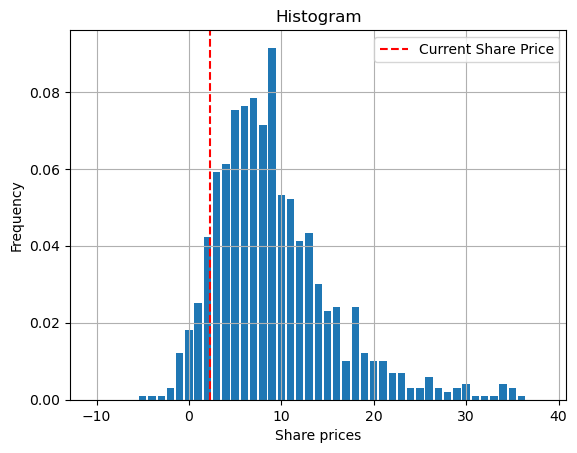

In [47]:
plt.hist(share_price_mt, bins=range(-10,40), align='left', rwidth=0.8, density=True)
plt.xlabel('Share prices')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.axvline(x=Current_Share_Price, color='red', linestyle='--', label='Current Share Price')
plt.legend()
plt.grid(True)

**Note:** In practical scenarios, negative current share prices are not possible. However, to maintain a more representative graph that reflects where the distribution is most concentrated, we have chosen to display negative values on the graph instead of replacing them with 0

## 8. Export to Excel

This part simply exports the relevant DataFrames we have computed into an Excel. This Excel is located in the same file as the one that contains the Jupyter Notebook.

In [48]:
with pd.ExcelWriter("{}.xlsx".format(your_company)) as writer:
    inc_df.to_excel(writer, sheet_name="Income Statement")
    ca_df.to_excel(writer, sheet_name="Cash-Flow Statement")
    bs_df.to_excel(writer, sheet_name="Balance Sheet")
    NWC_df.to_excel(writer, sheet_name="Net Working Capital")
    FCFF_df.to_excel(writer, sheet_name="FCFF")
    FCFF_vertical.to_excel(writer, sheet_name="FCFF Vertical Analysis")
    stat_NWC_df.to_excel(writer, sheet_name="NWC Statistics")
    stat_FCFF_df.to_excel(writer, sheet_name="FCFF Statistics")
    stat_FCFF_vertical_df.to_excel(writer, sheet_name="Vertical Analysis Statistics")
    Assumption_revenues_df.to_excel(writer, sheet_name="Assumption Revenues")
    forecasted_NWC_df.to_excel(writer, sheet_name="Forecasted NWC")
    Futur_FCFF_df.to_excel(writer, sheet_name="Forecasted FCFF")
    WACC_df.to_excel(writer, sheet_name="WACC")
    DCF_df.to_excel(writer, sheet_name="DCF")
writer.save()

/Users/paulsibille/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
